In [1]:
import os
import sys

json_file='config.json'

json_path=os.path.abspath(json_file)
if not os.path.isfile(json_path):
    print("ERROR: Please provide path to a valid config.json file...")
    print(sys.argv[1])
    exit(1)

    
workpath, jsonfile = os.path.split(json_path)
os.chdir(workpath)

In [2]:
import numpy as np
from itertools import islice
import math
import random
from collections import Counter
import matplotlib as mpl
import gzip, time, gc
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read config.json file
import json
# use abspath from argv
with open(json_path) as json_file:
    parameter = json.load(json_file)

from os import listdir
from os.path import isfile, join
import re

In [4]:
FASTQ_DIRS=parameter["FASTQ_DIRS"]
SAMPLE_NAMES=parameter['sample_names']
EXP_CELLS=parameter['EXP_CELLS']

if len(EXP_CELLS)!=len(SAMPLE_NAMES):
    print("ERROR: Expected cells must be provided for every sample")
    
try:
    tmp=SAMPLE_NAMES[0]
except TypeError:
    print("Sample names must be provided as a list (even when there is only one sample, e.g., 'sample1' ---> ['sample1'] ). ")

try:
    tmp=EXP_CELLS[0]
except TypeError:
    print("EXP_CELLS must be provided as a list (even when there is only one sample, e.g., 3000 ---> [3000] ). ")

print("Will process samples:")
for i in range(len(SAMPLE_NAMES)):
    print(' '+SAMPLE_NAMES[i]+" with ~%d cells"% EXP_CELLS[i])
    
print("\nWill look for the corresponding fastqs in the directories:")    
for d in FASTQ_DIRS:
    print(' '+d)

Will process samples:
 t_3k_small with ~3000 cells
 t_4k_small with ~4000 cells

Will look for the corresponding fastqs in the directories:
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_4k_fastqs_small/


In [5]:
barcode_filenames_per_sample = []
barcode_dirs_per_sample = []
read_filenames_per_sample = []
read_dirs_per_sample = []
for i_S in range(len(SAMPLE_NAMES)):
    barcode_filenames = []
    barcode_dirs = []
    read_filenames = []
    read_dirs = []
    for i_F in range(len(FASTQ_DIRS)):
        for f in sorted(listdir(str(FASTQ_DIRS[i_F]))):
            pattern = r"^"+str(SAMPLE_NAMES[i_S])+"_S\d+_L00\d_([IR]\d)_001.fastq.gz"
            match = re.match(pattern, f)
            if match:
                barcode_name = match.group(1)
            if isfile(join(str(FASTQ_DIRS[i_F]), f)) and f.startswith(str(SAMPLE_NAMES[i_S])) and barcode_name == 'R1':
                barcode_filenames.append(f)
                barcode_dirs.append(str(FASTQ_DIRS[i_F])+f)
            if isfile(join(str(FASTQ_DIRS[i_F]), f)) and f.startswith(str(SAMPLE_NAMES[i_S])) and barcode_name == 'R2':
                read_filenames.append(f)
                read_dirs.append(str(FASTQ_DIRS[i_F])+f)
    barcode_filenames_per_sample += [barcode_filenames]
    barcode_dirs_per_sample += [barcode_dirs]
    read_filenames_per_sample += [read_filenames]
    read_dirs_per_sample +=[read_dirs]
                
print("BARCODE FILES(R1):")
for i in range(len(barcode_dirs_per_sample)):
    print("\nsample: "+SAMPLE_NAMES[i])
    for j in range(len(barcode_dirs_per_sample[i])):
        print(" "+barcode_dirs_per_sample[i][j])
        
# print("\n----------------------------------------------------------------------------------------")
# print("READ FILES(R2):")
# for i in range(len(read_dirs_per_sample)):
#     print("\nsample: "+SAMPLE_NAMES[i])
#     for j in range(len(read_dirs_per_sample[i])):
#         print(" "+read_dirs_per_sample[i][j])

BARCODE FILES(R1):

sample: t_3k_small
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L001_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L002_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L003_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L004_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L005_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L006_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L007_R1_001.fastq.gz
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L008_R1_001.fastq.gz

sample: t_4k_small
 /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_4k_fastqs_small/t_4k_small_S1

In [6]:
random.seed()

save_dir=str(parameter["SAVE_DIR"])
#create output directory 
import os
if not os.path.isdir(save_dir):
    try:
        os.mkdir(save_dir)
    except OSError as e:
        print("OSError({0}): {1}".format(e.errno, e.strerror))

BARCODE_LENGTH=parameter['BARCODE_LENGTH']
output_dir = parameter['OUTPUT_DIR']
NUM_THREADS = parameter['NUM_THREADS']

In [7]:
def encoding_map(ch):
    if ch=='A':return 0
    if ch=='G':return 1
    if ch=='C':return 2
    if ch=='T':return 3
    if ch=='N':return random.randint(0,3)

decoding_lst = ['A', 'G', 'C', 'T']

def encode(k):
    code = 0
    for ch in k:
        code *= 4
        code += encoding_map(ch)
    return code

def decode(code):
    ret = ''
    for _ in range(parameter["BARCODE_LENGTH"]):
        index = code & 3
        code >>= 2
        ret = decoding_lst[index] + ret
    return ret

def read_barcodes(brc_dir):
    print(" Reading from "+brc_dir)
    barcodes=[]
    with gzip.open(brc_dir) as f:
        cnt=0
        for line in f:
            if cnt%4==1:
                line=line.decode('UTF-8')
                if len(line) <= parameter["BARCODE_LENGTH"]:
                    seq_added = "".join('N' for i in range(parameter["BARCODE_LENGTH"] + 10 - (len(line)-1)))
                    line = line[0:-1] + seq_added
                    print(brc_dir)
                    print(cnt, line)
                    barcodes+=[encode(line[0:parameter["BARCODE_LENGTH"]])]  # extract barecode 
                else: 
                    barcodes+=[encode(line[0:parameter["BARCODE_LENGTH"]])]  # extract barcode from barcode 
            cnt+=1;            
    return barcodes

def hamdist(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [8]:
####### READ BARCODES for each sample
barcodes_per_sample=[]
for i_S in range(len(SAMPLE_NAMES)):
    print("READ_BARCODES for sample "+SAMPLE_NAMES[i_S]+':')
    brc_dirs = barcode_dirs_per_sample[i_S] if len(SAMPLE_NAMES)>1 else barcode_dirs_per_sample
    
    p=Pool(NUM_THREADS)
    t0 = time.time()
    barcode_vec=p.map(read_barcodes, brc_dirs )
    p.close()
    p.join()

    barcodes = np.array([item for sublist in barcode_vec for item in sublist],dtype='uint32')

    del barcode_vec[:];del barcode_vec; #del all_bars
    _ = gc.collect()
    
    barcodes_per_sample +=[barcodes]
    print('')

t1 = time.time()
print(t1-t0, "sec")

READ_BARCODES for sample t_3k_small:
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L001_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L005_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L004_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L007_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L002_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L008_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L003_R1_001.fastq.gz
 Reading from /home/vasilis/clustering_EQ/10xTCC_prep/example_data/t_3k_fastqs_small/t_3k_small_S1_L006_R1_001.fastq.gz

RE

In [9]:
for i_S in range(len(SAMPLE_NAMES)):
    print(SAMPLE_NAMES[i_S]+" barcodes:\n")
    barcodes = barcodes_per_sample[i_S] if len(SAMPLE_NAMES)>1 else barcodes_per_sample
    for bar in barcodes[:10]:
           print(' '+decode(bar))
    print(" ...")
    print(" NUMBER_OF_SEQUENCED_BARCODES =",len(barcodes))

t_3k_small barcodes:

 CCATTTGAGTAACC
 TAAGCGTCAGTATA
 GATCAAGGTGCAGG
 ACACCTACAAACTG
 GCTAGCTAGGTGCA
 ACTGCAGGTAGGGA
 CCGCAGTTCACATA
 GGTCAGGCAGTACA
 GCTGCTCAGACCTA
 CAACCTCCAGTCGA
 ...
 NUMBER_OF_SEQUENCED_BARCODES = 80000
t_4k_small barcodes:

 GGCGGTTCATTGGG
 TCACGGAGTGAGTA
 TTTACTGAGCCCGA
 GTGTGCGCATTCTT
 CGTCACTGTGTGAC
 GAAGGCCTCTTACC
 CGTGTTAAGACCTT
 GCATACAGTAGGAC
 CAGAGAGGTCGAAC
 CACTTACTCGTCGT
 ...
 NUMBER_OF_SEQUENCED_BARCODES = 80000


Detecting Cells for t_3k_small ...
NUM_OF_DISTINCT_BARCODES = 13378


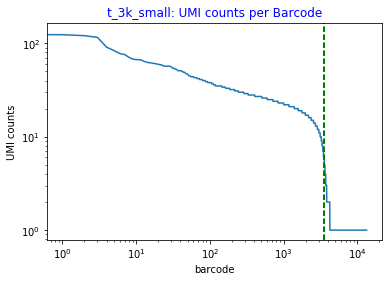

Cell_barcodes_detected: 3563
NUM_OF_READS_in_CELL_BARCODES = 68998
Detecting Cells for t_4k_small ...
NUM_OF_DISTINCT_BARCODES = 14396


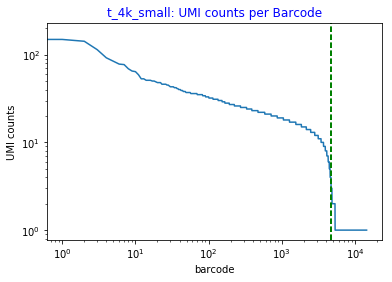

Cell_barcodes_detected: 4691
NUM_OF_READS_in_CELL_BARCODES = 69519


In [10]:
codewords_per_sample=[]
if parameter["use_precomputed_barcodes"]==0:
    for i_S in range(len(SAMPLE_NAMES)):

        print("Detecting Cells for "+SAMPLE_NAMES[i_S]+" ...")
        barcodes = barcodes_per_sample[i_S] if len(SAMPLE_NAMES)>1 else barcodes_per_sample

        counts = Counter(barcodes)
        labels, values = zip(*counts.items())

        # sort your values in descending order
        indSort = np.argsort(values)[::-1]

        # rearrange your data
        labels = np.array(labels)[indSort]
        values = np.array(values)[indSort]

        indices = np.arange(len(labels))
        print("NUM_OF_DISTINCT_BARCODES =",len(indices))

        # we apply the cellranger thresholding here - 1st percentile
        # the user has provided the expected cells parameter and we take the 1st percentile

        EXP_CELLS=int(math.floor(parameter["EXP_CELLS"][i_S] * 0.01 - 1))
        exp_values = np.where(values >= values[EXP_CELLS] / 10)

        NUM_OF_BARCODES = np.shape(exp_values)[1]


        fig, ax = plt.subplots()
        ax.plot(indices, (values))
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
        ax.set_ylabel('UMI counts', color='k')
        ax.set_xlabel('barcode', color='k')
        ax.set_title(SAMPLE_NAMES[i_S]+': UMI counts per Barcode', color='b')
        ax.axvline(NUM_OF_BARCODES, color='g', linestyle='--',linewidth=2.0)
        fig.savefig(str(parameter["SAVE_DIR"])+SAMPLE_NAMES[i_S]+'_umi_barcodes.png')
        plt.show()
        print("Cell_barcodes_detected:",NUM_OF_BARCODES)
        print("NUM_OF_READS_in_CELL_BARCODES =",sum(values[:NUM_OF_BARCODES]))

        codewords_per_sample+=[labels[:NUM_OF_BARCODES]]

    ## CLEANUP
    #del indices; del labels; del values; del counts; del valdiff; del indSort; del Ham_dist; del dmin
    del indices; del labels; del values; del counts; del indSort; 
    _ = gc.collect()       
else:
    print("Will use precomputed cell barcodes for each sample:")
    for i_S in range(len(SAMPLE_NAMES)):
        print(SAMPLE_NAMES[i_S]+'->'+parameter["precomputed_barcode_files"][i_S])
        load_barcodes=np.loadtxt(parameter["precomputed_barcode_files"][i_S],dtype=str,delimiter='\n')
        brcs=[]
        for i in load_barcodes:
            brcs+=[encode(i)]
        print("Number of cell barcodes:",len(brcs))
        codewords_per_sample+=[brcs]

In [11]:
#Choose barcodes to error correct based on d_min

###########################################
def is_far_enough(i):
    d=parameter['dmin']
    dmin=100000
    codi=decode(codewords[i])
    j_range=list(np.arange(1,i))+list(np.arange(i+1,len(codewords)))
    while dmin>=d and len(j_range)>0:
        j=j_range.pop()
        dmin=np.min([dmin,hamdist(codi,decode(codewords[j]))])

    return i if dmin>=d else -1
###########################################    

t0 = time.time()
d=parameter['dmin']

brc_idx_to_correct_per_sample=[]
for i_S in range(len(SAMPLE_NAMES)):
    print("\nCalculating d_min for "+SAMPLE_NAMES[i_S]+" ...")
    
    codewords=codewords_per_sample[i_S] if len(SAMPLE_NAMES)>1 else codewords_per_sample
    p=Pool(2*NUM_THREADS)
    ret_vec=p.map(is_far_enough, np.arange(len(codewords)) )
    p.close()
    p.join()

    brc_idx_to_correct = [i for i in ret_vec if i>=0]
    print("-- number of cell barcodes to error-correct:", len(brc_idx_to_correct), "( dmin >=", d,")" )  
    
    brc_idx_to_correct_per_sample += [brc_idx_to_correct] 
    
t1 = time.time()
print('\n',t1-t0, "sec")


Calculating d_min for t_3k_small ...
-- number of cell barcodes to error-correct: 1124 ( dmin >= 4 )

Calculating d_min for t_4k_small ...
-- number of cell barcodes to error-correct: 985 ( dmin >= 4 )

 89.0478265285492 sec


In [12]:
print("Writing output...")

import pickle
save_dir=str(parameter["SAVE_DIR"])

        
for i_S in range(len(SAMPLE_NAMES)):
    barcodes=barcodes_per_sample[i_S] if len(SAMPLE_NAMES)>1 else barcodes_per_sample
    codewords=codewords_per_sample[i_S] if len(SAMPLE_NAMES)>1 else codewords_per_sample
    brc_idx_to_correct=brc_idx_to_correct_per_sample[i_S] if len(SAMPLE_NAMES)>1 else brc_idx_to_correct_per_sample
    with open(save_dir+SAMPLE_NAMES[i_S]+"_barcodes.dat", 'wb') as f:
        pickle.dump(barcodes,f)
    with open(save_dir+SAMPLE_NAMES[i_S]+"_codewords.dat", 'wb') as f:
        pickle.dump(codewords,f)
    with open(save_dir+SAMPLE_NAMES[i_S]+"_brc_idx_to_correct.dat", 'wb') as f:
        pickle.dump(brc_idx_to_correct,f)

        
### let the workflow know that the notebook version of get_cell_barcodes has been executed
with open(str(parameter["SAVE_DIR"])+"notebook.cookie", 'w') as f:
                   f.write(str(SAMPLE_NAMES))
        
print("DONE")

Writing output...
DONE
